In [1]:
from sklearn import datasets
from sklearn.metrics import mean_squared_error as mse
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = datasets.load_boston()

In [3]:
print(data['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [4]:
data['data'][0]

array([  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
         0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
         6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
         2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
         4.98000000e+00])

In [5]:
data['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], 
      dtype='|S7')

In [94]:
class Node:
    def __init__(self):
        self.val = {'p' : -1, 'k' : -1}
        self.mean1 = -1
        self.mean2 = -1
        self.left_child = -1
        self.right_child = -1 
        self.mean = -1

In [116]:
class Tree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.mse_treshold = 1
        self.array = []
        for i in xrange(2 ** (max_depth + 2)):
            self.array.append(Node())
        
    @staticmethod    
    def MSE(p, k, X, y):
        y_pred = np.zeros_like(y)
        y_pred[np.argwhere(X[:, k] > p).transpose()] \
        = y[np.argwhere(X[:, k] > p).transpose()].mean()
        y_pred[np.argwhere(X[:, k] <= p).transpose()] \
        = y[np.argwhere(X[:, k] <= p).transpose()].mean()
        return mse(y, y_pred)  

    def Build(self, X_train, y_train):
        self.build(X_train, y_train, 0)
    
    def build(self, X, y, node_ind):
        if len(y) <= 1:
            return
        values = np.zeros(X.shape[1])
        p_s = np.zeros(X.shape[1])
        val_s = np.zeros(X.shape[1])
        for k in xrange(X.shape[1]):
            min_ = optimize.differential_evolution(lambda p: Tree.MSE(p, k, X, y), 
                                                   bounds=[(np.min(X[:, k]),
                                                           np.max(X[:, k]))])
            p_s[k] = min_.fun
            val_s[k] = min_.x[0]            
            
        k = np.argmin(p_s)
        p = val_s[k]
        self.array[node_ind].val['p'] = p
        self.array[node_ind].val['k'] = k
        a = node_ind
        
        if (2 * node_ind + 2 < 2 ** self.max_depth - 1):
            self.build(X[X[:, k] <= p], y[X[:, k] <= p], 2 * node_ind + 1)
            self.build(X[X[:, k] > p], y[X[:, k] > p], 2 * node_ind + 2)
            self.array[node_ind].left_child = 2 * node_ind + 1
            self.array[node_ind].right_child = 2 * node_ind + 2   
            self.array[node_ind].mean1 = y[np.argwhere(X[:, k] <= p).transpose()].mean()
            self.array[node_ind].mean2 = y[np.argwhere(X[:, k] > p).transpose()].mean()
            
   

In [130]:
class DecisionTree:
    def __init__(self, max_depth=4, mse_treshold=1):
        self.Tree = Tree(max_depth)
        self.max_depth = max_depth
        self.mse_treshold = mse_treshold
        pass
    def fit(self, X_train, y_train):
        self.Tree.Build(X_train, y_train)
    
    def _predict(self, el):
        pred = -1
        node_ind = 0
        while (self.Tree.array[node_ind].mean1 != -1):
            if el[self.Tree.array[node_ind].val['k']] <= self.Tree.array[node_ind].val['p']:
                pred = self.Tree.array[node_ind].mean1
                node_ind = 2 * node_ind + 1
                
            else:
                pred = self.Tree.array[node_ind].mean2
                node_ind = 2 * node_ind + 2
                
        return pred
                
    def predict(self, X_test):
        y_pred = np.zeros(X_test.shape[0]) - 1
        for j in xrange(X_test.shape[0]):
            y_pred[j] = DecisionTree._predict(self, X_test[j, :])
        return y_pred              
            
           

In [129]:
dt.Tree.array[7].val

{'k': 0, 'p': 11.717777262297052}

In [131]:
dt = DecisionTree()

In [132]:
dt.fit(data['data'][:-10], data['target'][:-10])

In [133]:
dt.predict(data['data'][-10:])

array([ 18.10909091,  23.01687243,  23.01687243,  18.10909091,
        23.01687243,  23.01687243,  23.01687243,  33.57380952,
        23.01687243,  23.01687243])

In [91]:
model.fit(data['data'][:-10], data['target'][:-10])

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [93]:
model.predict(data['data'][-10:])

array([ 19.8       ,  21.73157895,  21.73157895,  19.8       ,
        21.73157895,  27.6245283 ,  21.73157895,  32.97      ,
        27.6245283 ,  21.73157895])

In [57]:
t = Tree(4)

In [58]:
t.Build(data['data'], data['target'])

In [59]:
print (t.array[0].val)
print (t.array[1].val, t.array[2].val)
print(t.array[3].val,t.array[4].val,t.array[5].val,t.array[6].val)
print(t.array[7].val,t.array[8].val,t.array[9].val,t.array[10].val, t.array[11].val,t.array[12].val,t.array[13].val,t.array[14].val)

{'p': 6.942712738043765, 'k': 5}
({'p': 14.378613861580433, 'k': 12}, {'p': 7.4419173772115554, 'k': 5})
({'p': 1.3816443703268835, 'k': 7}, {'p': 0.60629586628474941, 'k': 4}, {'p': 7.0692933459239597, 'k': 0}, {'p': 3.2701440407168185, 'k': 0})
({'p': 10.881642094493639, 'k': 0}, {'p': 6.5410165481443894, 'k': 5}, {'p': 0.51762086024031362, 'k': 0}, {'p': 19.760167517809755, 'k': 12}, {'p': 6.1205617671892334, 'k': 0}, {'p': 27.597366468562278, 'k': 0}, {'p': 14.894252602352035, 'k': 10}, {'p': -1, 'k': -1})


In [38]:
import pydotplus 
import pandas as pd

from IPython.display import Image
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
model = tree.DecisionTreeRegressor(max_depth=4)
model.fit(data['data'], data['target'])

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [52]:
dot_data = tree.export_graphviz(model, out_file="tree.out", 
                         feature_names=map(str, np.arange(data['data'].shape[1])),
                         class_names=['0', '1'],  
                         filled=True, rounded=True,  
                         special_characters=True)  

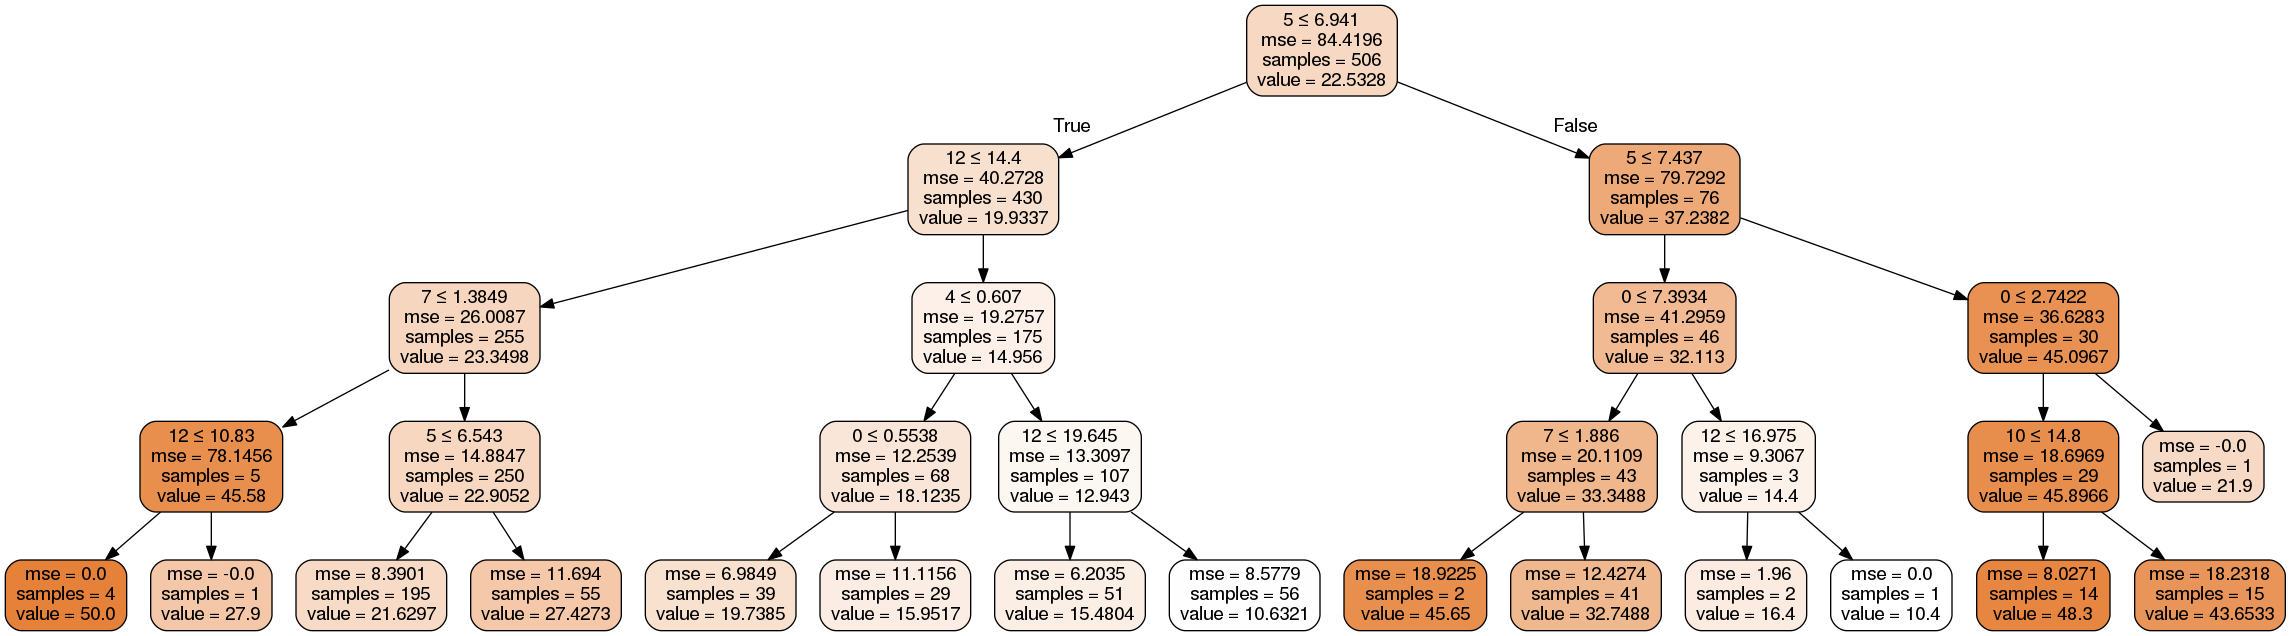

In [53]:
graph = pydotplus.graphviz.graph_from_dot_file("tree.out")  
Image(graph.create_png()) 